# Solving the $L^p$ problem using the L2 solution

We can generalise the problem and results of this exercise to the 2D domain. We now consider the space to be $[0,1] \times [0,1]$. We perform uniform sampling using $N^2$ samples along a uniform square grid of size $N \times N$. We consider the $L^p$ optimisation problem:

$$
\min_{\hat{f}} \mathcal{E}^p(f, \hat{f}) = \min_{\hat{f}} \int_{[0,1]^2} | f(x) - \hat{f}(x) |^p w(x) dx
$$

$$
= \min_{\hat{f}} \int \int_{[0,1] \times [0,1]} | f(x_1, x_2) - \hat{f}(x_1, x_2) |^p w(x_1, x_2) dx_1 dx_2,
$$

The signal $f$ will be an image of your choosing, encoded with values in $[0,1]$, such as the one from the previous exercises. You may wish to try with various images to see what happens and comment on it.


Comments and comparisons should be both visual (i.e. qualitative) and based on some measures (i.e. quantitative).

1. Generalise and give without proof the pseudo-code of the approximate $L^p$ solver using $L^2$ solutions from exercise 1.f.

2. Implement this algorithm by a function with inputs $f$, $N$, and $\epsilon > 0$.

3. Implement another function that solves the $L^1$ problem without approximation and without using this algorithm.

4. Compare the results you obtain for the $L^1$ solution using the exact algorithm and the approximate algorithm. Study the behaviour for varying $N$ and $\epsilon$.

5. Run your algorithm on the same image to compute the approximate $L^{3/2}$ and $L^4$ solutions. Comment on your results.


## Function to Approximate the Lp Solution in 2D Using IRLS

In [1]:
def approximate_lp_solver_2d(f, N, p, epsilon=1e-5, delta=1e-5, max_iter=100):
    """
    Approximates the solution to the weighted Lp optimization problem in 2D using IRLS.

    Parameters:
    - f: 2D NumPy array representing the image with values in [0,1]
    - N: Number of grid divisions along each axis (image is divided into N x N blocks)
    - p: Exponent in Lp norm (p >= 1)
    - epsilon: Small constant to prevent division by zero
    - delta: Convergence tolerance
    - max_iter: Maximum number of iterations

    Returns:
    - f_approx: Approximated image as a 2D NumPy array
    """
    import numpy as np

    # Get image dimensions
    height, width = f.shape
    block_height = height // N
    block_width = width // N

    # Initialize f_approx with the mean of each block
    f_approx = np.zeros_like(f)
    f_approx_values = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            x_start = i * block_height
            x_end = (i + 1) * block_height
            y_start = j * block_width
            y_end = (j + 1) * block_width

            block = f[x_start:x_end, y_start:y_end]
            f_approx_value = np.mean(block)
            f_approx_values[i, j] = f_approx_value
            f_approx[x_start:x_end, y_start:y_end] = f_approx_value

    # Iterative process
    for iteration in range(max_iter):
        convergence = True

        for i in range(N):
            for j in range(N):
                x_start = i * block_height
                x_end = (i + 1) * block_height
                y_start = j * block_width
                y_end = (j + 1) * block_width

                block = f[x_start:x_end, y_start:y_end]
                f_approx_value = f_approx_values[i, j]

                # Compute weight function w'
                diff = np.abs(block - f_approx_value)
                weight = np.minimum(1/epsilon, diff**(p - 2))

                # Update f_approx_value
                numerator = np.sum(weight * block)
                denominator = np.sum(weight)

                if denominator == 0:
                    f_new = f_approx_value
                else:
                    f_new = numerator / denominator

                # Check convergence
                if np.abs(f_new - f_approx_value) > delta:
                    convergence = False

                # Update f_approx_value
                f_approx_values[i, j] = f_new
                f_approx[x_start:x_end, y_start:y_end] = f_new

        if convergence:
            print(f'Converged in {iteration + 1} iterations.')
            break

    return f_approx


## Function to Solve the L1 Problem Exactly in 2D

In [2]:
def exact_l1_solver_2d(f, N):
    """
    Solves the weighted L1 optimization problem exactly in 2D.

    Parameters:
    - f: 2D NumPy array representing the image with values in [0,1]
    - N: Number of grid divisions along each axis

    Returns:
    - f_median: Image reconstructed using the median of each block
    """
    import numpy as np

    # image dimensions
    height, width = f.shape
    block_height = height // N
    block_width = width // N

    f_median = np.zeros_like(f)

    for i in range(N):
        for j in range(N):
            x_start = i * block_height
            x_end = (i + 1) * block_height
            y_start = j * block_width
            y_end = (j + 1) * block_width

            block = f[x_start:x_end, y_start:y_end]
            median_value = np.median(block)
            f_median[x_start:x_end, y_start:y_end] = median_value

    return f_median


## Compare the Results for the L1 Solution Using the Exact Algorithm and the Approximate Algorithm

Converged in 32 iterations.


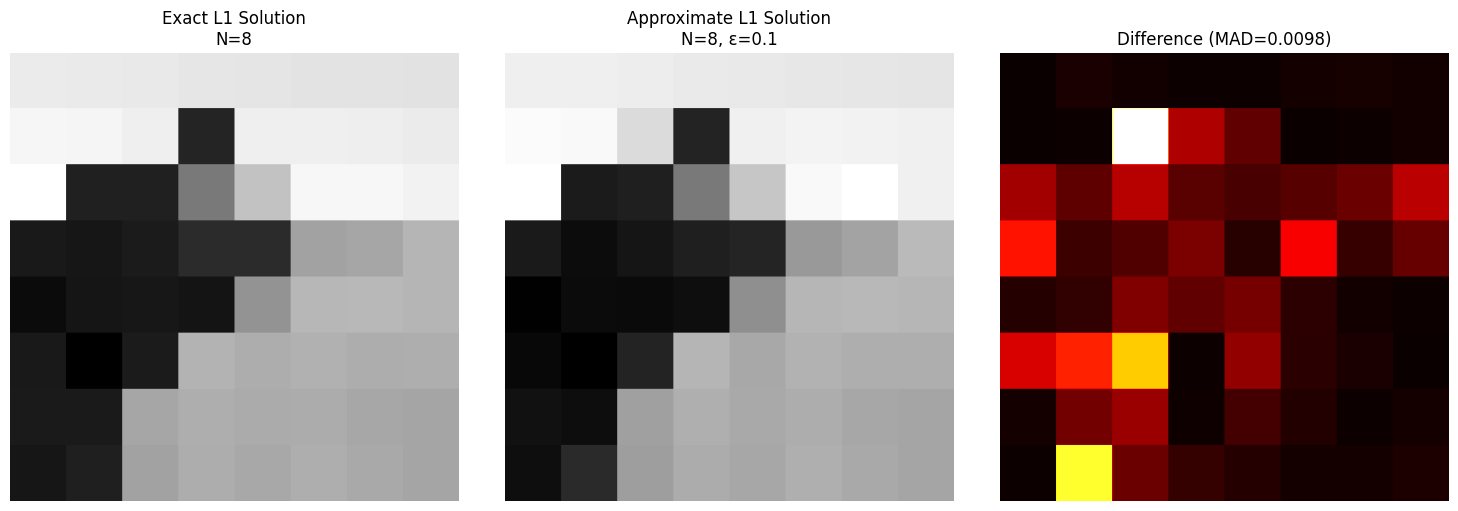

Converged in 75 iterations.


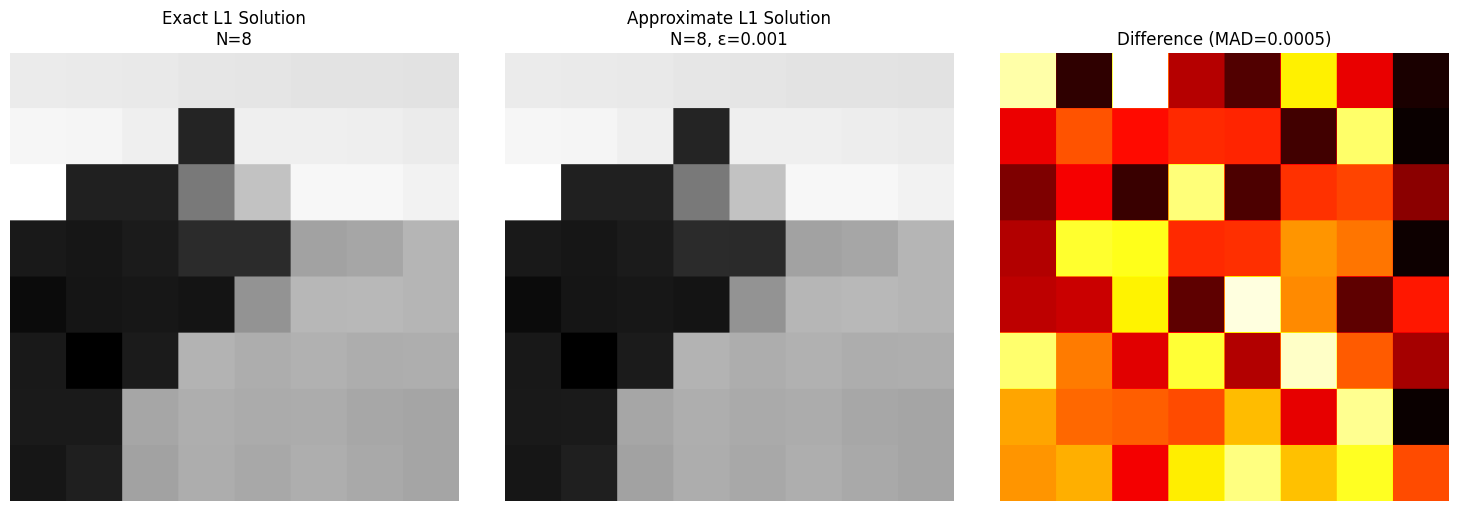

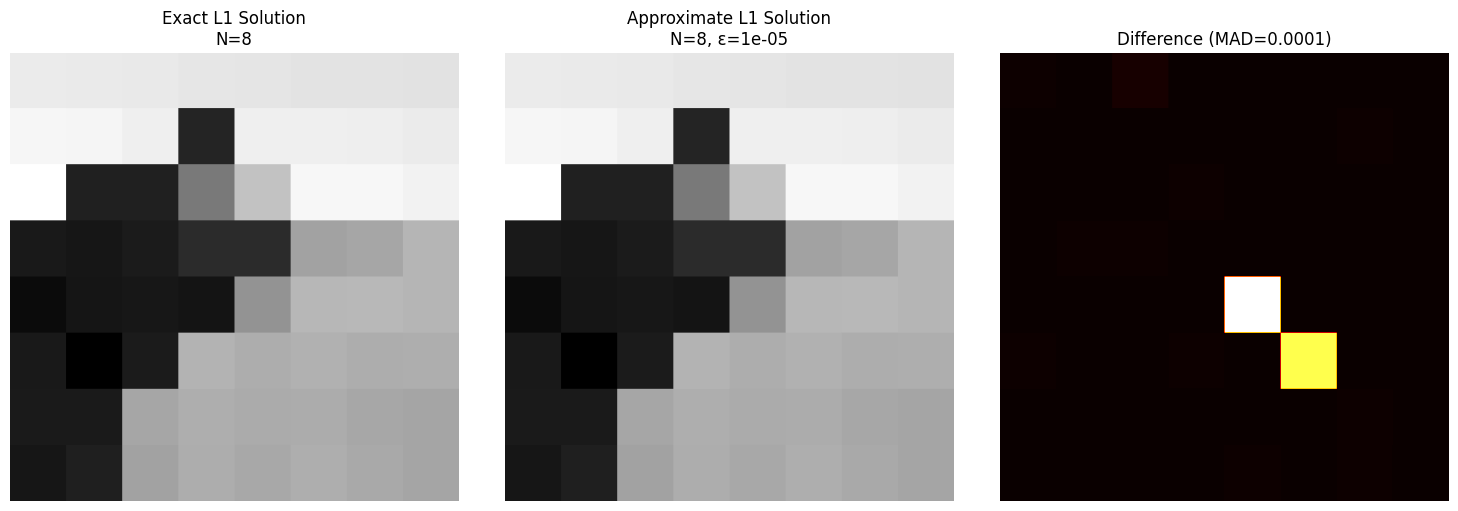

Converged in 93 iterations.


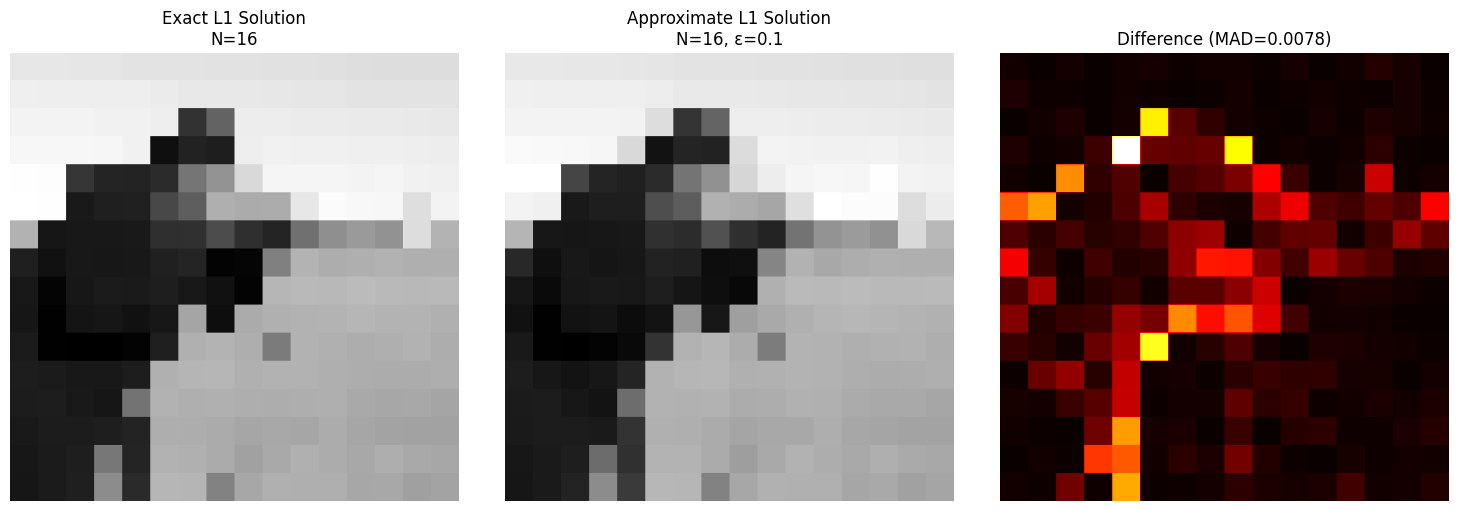

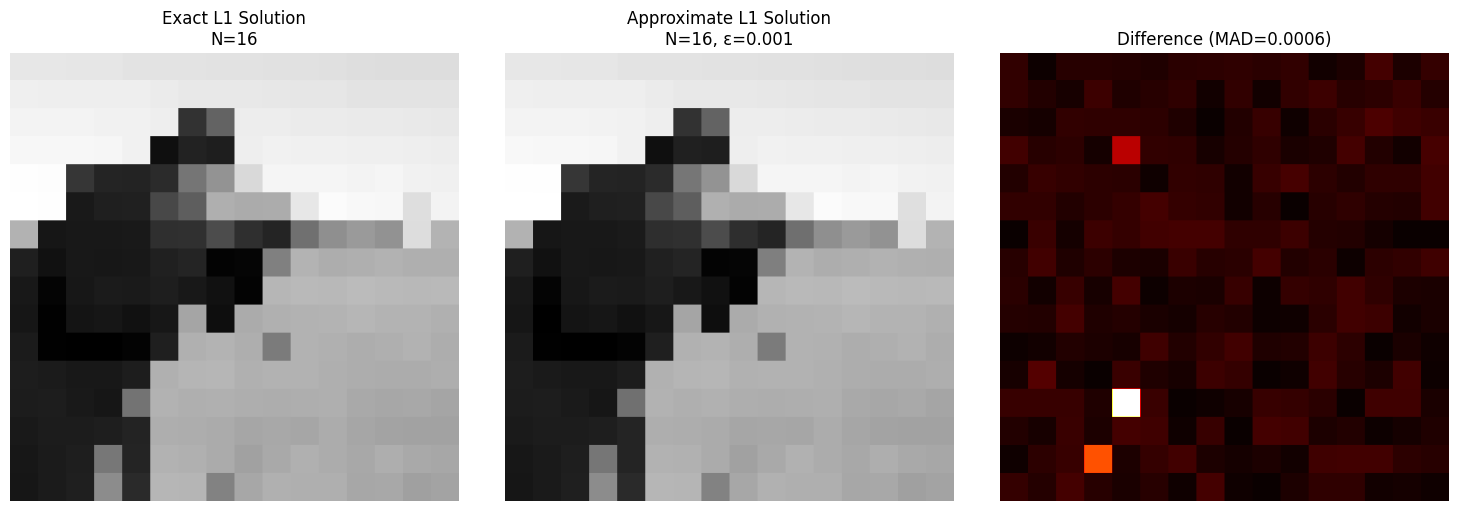

<ipython-input-1-3622206bdbb3>:55: RuntimeWarning: divide by zero encountered in reciprocal
  weight = np.minimum(1/epsilon, diff**(p - 2))


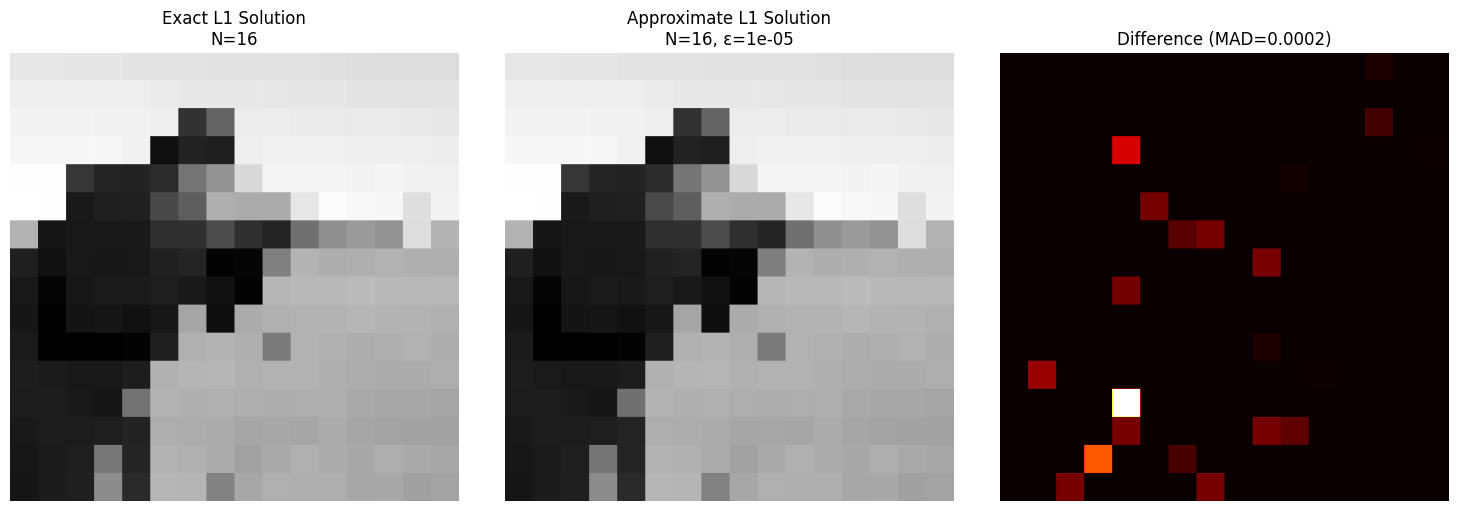

Converged in 84 iterations.


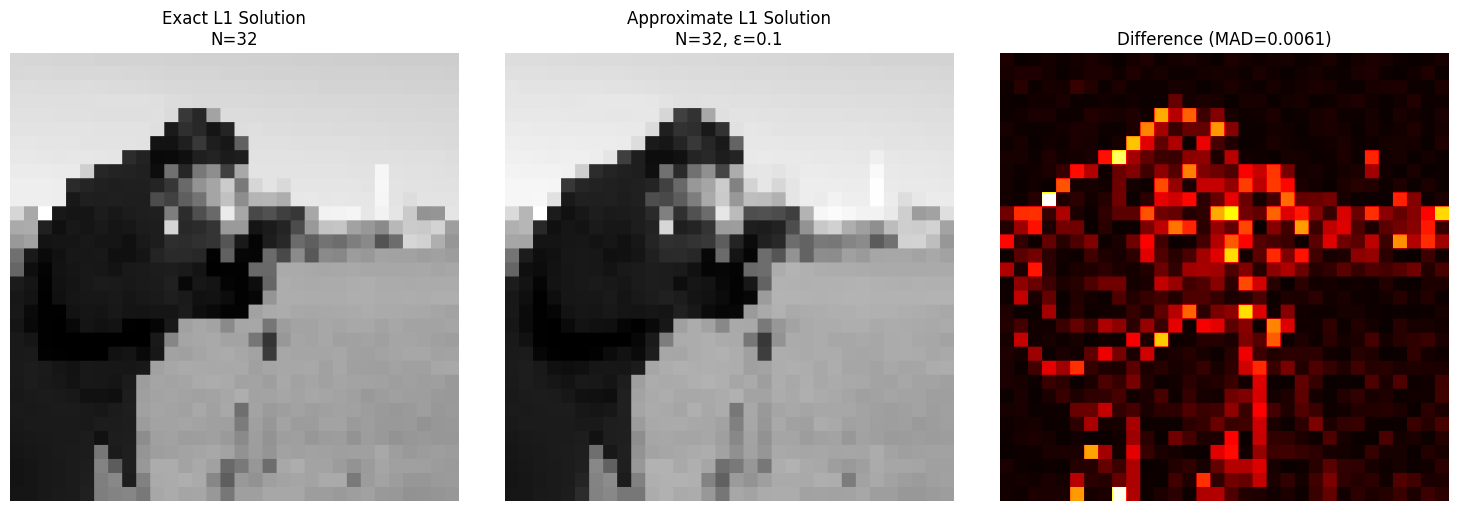

Converged in 73 iterations.


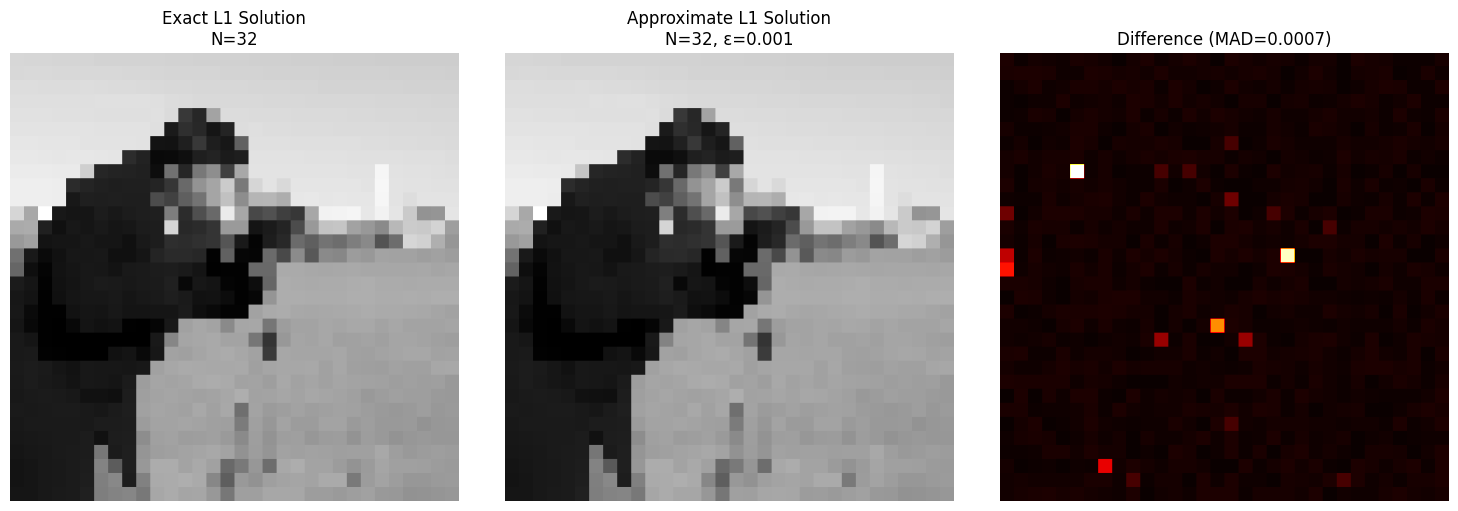

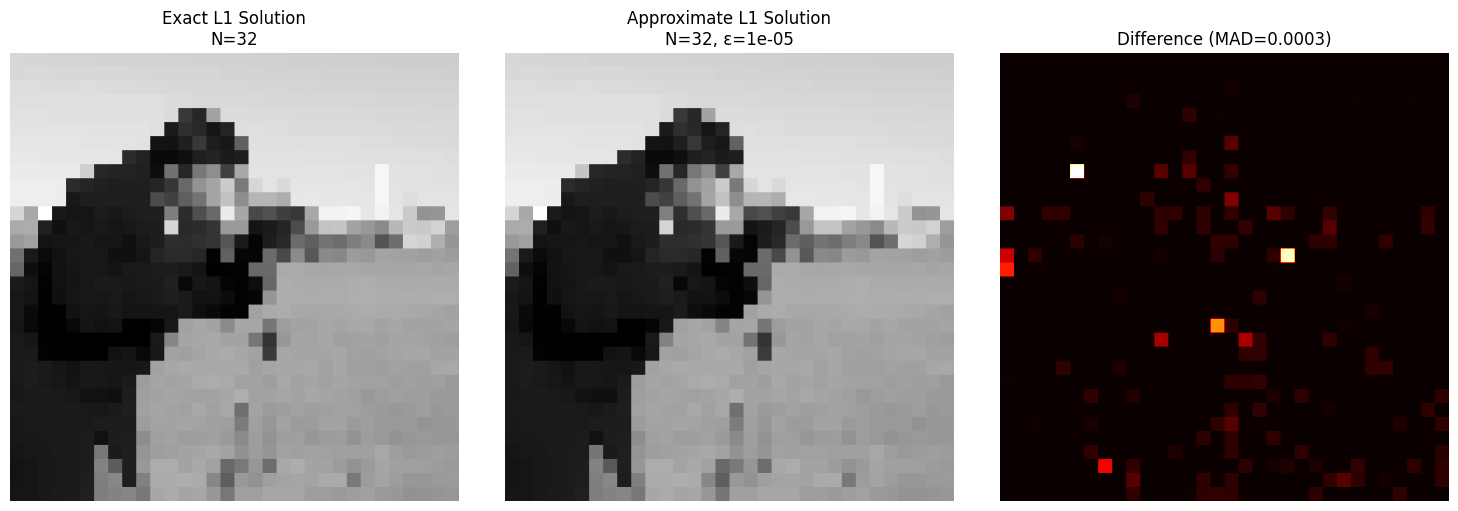

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float

f = img_as_float(data.camera())

# Normalize the image to [0,1] if necessary
f = (f - f.min()) / (f.max() - f.min())

# Example values for N and epsilon
N_values = [8, 16, 32]
epsilon_values = [1e-1, 1e-3, 1e-5]

for N in N_values:
    for epsilon in epsilon_values:
        f_exact_l1 = exact_l1_solver_2d(f, N)
        f_approx_l1 = approximate_lp_solver_2d(f, N, p=1, epsilon=epsilon)

        difference = np.abs(f_exact_l1 - f_approx_l1)
        mad = np.mean(difference)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(f_exact_l1, cmap='gray')
        plt.title(f'Exact L1 Solution\nN={N}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(f_approx_l1, cmap='gray')
        plt.title(f'Approximate L1 Solution\nN={N}, ε={epsilon}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap='hot')
        plt.title(f'Difference (MAD={mad:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


## On the Same Image to Compute the Approximate $L^{3/4}$ and $L^4$ Solutions.

<ipython-input-1-3622206bdbb3>:55: RuntimeWarning: divide by zero encountered in power
  weight = np.minimum(1/epsilon, diff**(p - 2))


Converged in 78 iterations.


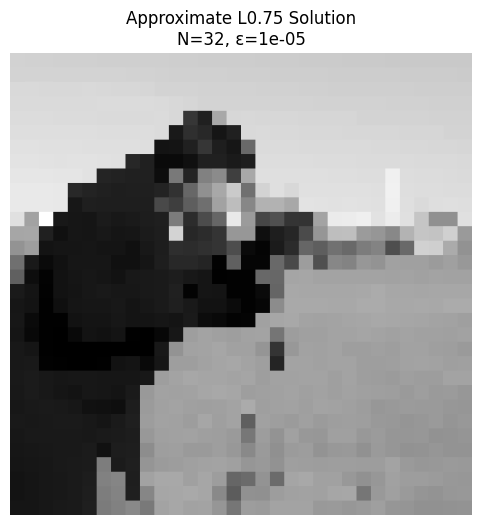

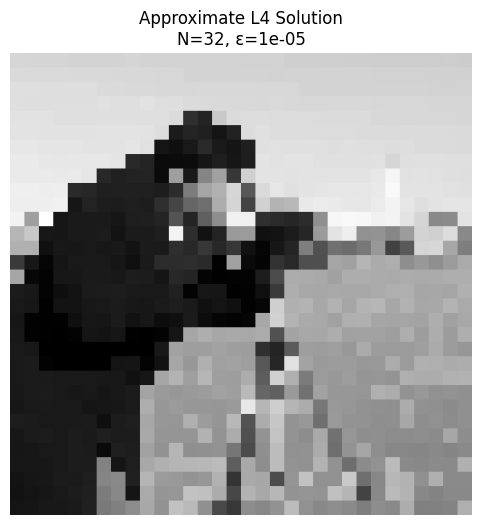

In [7]:
# Values of p to test
p_values = [3/4, 4]

N = 32
epsilon = 1e-5

for p in p_values:
    f_approx = approximate_lp_solver_2d(f, N, p=p, epsilon=epsilon)

    plt.figure(figsize=(6, 6))
    plt.imshow(f_approx, cmap='gray')
    plt.title(f'Approximate L{p} Solution\nN={N}, ε={epsilon}')
    plt.axis('off')
    plt.show()
